<a href="https://colab.research.google.com/github/SaulNunez/Notas-Curso-Deep-Learning-IA.Center/blob/master/proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

tf.__version__

'2.5.0'

In [ ]:
# CNN params

img_dimensions = 500
img_channels = 1
img_mode = 'grayscale'

In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (img_dimensions, img_dimensions, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-08-03 04:52:29--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M  45.2MB/s    in 1.9s    

2021-08-03 04:52:31 (45.2 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0       

In [ ]:
from tensorflow.keras.optimizers import RMSprop


x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

## Download dataset

In [ ]:
!pip install kaggle

In [ ]:
!KAGGLE_CONFIG_DIR=/content/kaggle kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:12<00:00, 81.6MB/s]
100% 1.14G/1.14G [00:12<00:00, 97.7MB/s]


## Prepare for ingest

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '/content/pneumonia-xray-images.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/pneumonia-xray-images')
zip_ref.close()

# Define our example directories and files
base_dir = '/content/pneumonia-xray-images'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

train_normal_dir = os.path.join(train_dir, 'normal')
train_pneumonia_dir = os.path.join(train_dir, 'opacity')
validation_normal_dir = os.path.join(validation_dir, 'normal')
validation_pneumonia_dir = os.path.join(validation_dir, 'opacity')

train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   vertical_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_dimensions, 
                                                                 img_dimensions),
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    shuffle=False)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         target_size=(img_dimensions, 
                                                                 img_dimensions),
                                                          batch_size=20,
                                                          class_mode='binary')

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


## Img samples

In [ ]:
import matplotlib.pyplot as plt

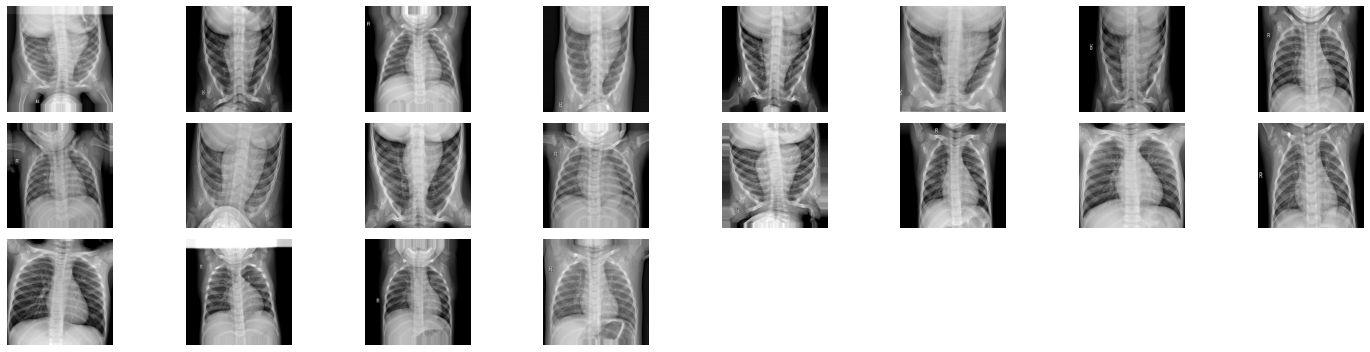

In [ ]:
from keras.preprocessing.image import array_to_img

image_batch = train_generator[0][0]

plt.figure(figsize=(20,5))
for i in range(len(image_batch)):
    plt.subplot(3,8,i + 1)
    pil_img = array_to_img(image_batch[i])
    plt.imshow(pil_img,cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
train_generator.reset()

Reduce overfitting

In [ ]:
def scheduler(epoch,learning_rate):
  if epoch < 10:
    return learning_rate
  else:
    return learning_rate * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=40,
    epochs=100,
    validation_steps=50,
    verbose=1
)

Epoch 1/100
40/40 [==============================] - 99s 2s/step - loss: 43.7207 - accuracy: 0.6750 - val_loss: 2.0281 - val_accuracy: 0.7430
Epoch 2/100
40/40 [==============================] - 69s 2s/step - loss: 0.5037 - accuracy: 0.8675 - val_loss: 0.1604 - val_accuracy: 0.9420
Epoch 3/100
40/40 [==============================] - 65s 2s/step - loss: 0.2368 - accuracy: 0.8825 - val_loss: 0.1003 - val_accuracy: 0.9690
Epoch 4/100
40/40 [==============================] - 65s 2s/step - loss: 0.2018 - accuracy: 0.9425 - val_loss: 0.1435 - val_accuracy: 0.9430
Epoch 5/100
40/40 [==============================] - 64s 2s/step - loss: 0.1488 - accuracy: 0.9413 - val_loss: 0.0948 - val_accuracy: 0.9740
Epoch 6/100
40/40 [==============================] - 65s 2s/step - loss: 0.1461 - accuracy: 0.9413 - val_loss: 0.1492 - val_accuracy: 0.9420
Epoch 7/100
40/40 [==============================] - 65s 2s/step - loss: 0.1413 - accuracy: 0.9425 - val_loss: 0.0861 - val_accuracy: 0.9750
Epoch 8/100


## Accuracy of generated model

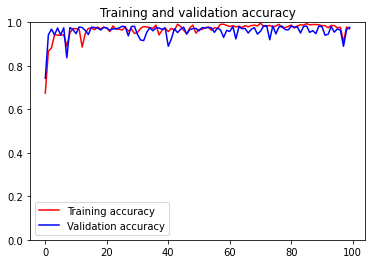

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.ylim([0, 1])
plt.figure()


plt.show()

## Tests

In [ ]:
import random

test_dir = os.path.join(base_dir, 'test')

test_normal_dir = os.path.join(train_dir, 'normal')
test_pneumonia_dir = os.path.join(train_dir, 'opacity')

test_normal_fnames = os.listdir(test_normal_dir)
test_opacity_fnames = os.listdir(test_pneumonia_dir)

test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory( test_dir,
                                  class_mode=None, 
                                  target_size=(img_dimensions, img_dimensions),
                                  shuffle=False)

Found 624 images belonging to 2 classes.


In [ ]:
import numpy as np
import pandas as pd

predictions_md =  model.predict(test_generator, verbose=1)

predictions_md[predictions_md <= 0.5] = 0
predictions_md[predictions_md > 0.5] = 1

20/20 [==============================] - 14s 456ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predictions_md, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])

cm

,Predicted Normal,Predicted Pneumonia
Actual Normal,189,45
Actual Pneumonia,6,384
